# Part C — Failure-Aware Segmentation Evaluation

Post-hoc evaluation of three trained segmentation models (brain specialist, pneumothorax specialist, mixed) under five conditions per modality. No retraining. No GT required for the reliability signal itself.

**Five cases evaluated (per modality):**
| # | Name | Model | Data |
|---|------|-------|------|
| 1 | Correct routing, clean | Specialist | Clean test |
| 2 | Mixed model, clean | Mixed | Clean test |
| 3 | Correct routing, noisy | Specialist | Noisy test |
| 4 | Mixed model, noisy | Mixed | Noisy test |
| 5 | Misroute (ablation) | Wrong specialist | Noisy test |

**Reliability signal = Uncertainty (MC Dropout) + Plausibility (area + connectivity)**

In [34]:
import os, gc, warnings
warnings.filterwarnings('ignore')
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm.auto import tqdm
from typing import List, Tuple, Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

print(f"PyTorch : {torch.__version__}")
print(f"CUDA    : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU     : {torch.cuda.get_device_name(0)}")

PyTorch : 2.7.1+cu118
CUDA    : True
GPU     : NVIDIA GeForce RTX 3060 Laptop GPU


In [35]:
# ============================================================
# PART C CONFIG  —  edit these values freely
# ============================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- MC Dropout ---
N_MC = 20                 # stochastic forward passes

# --- Prediction threshold ---
THRESHOLD = 0.5

# --- ImageNet normalisation (used during training for all models) ---
# Grayscale images are scaled to [0,1] then normalised per-channel.
# For in_channels=1 the grayscale equivalents (channel-average) are used.
IMAGENET_MEAN      = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD       = np.array([0.229, 0.224, 0.225], dtype=np.float32)
IMAGENET_MEAN_GRAY = 0.449   # mean of the three ImageNet channel means
IMAGENET_STD_GRAY  = 0.226   # mean of the three ImageNet channel stds

# --- Test-time noise (applied on-the-fly, never saved) ---
# Noise added in ImageNet-normalised space (values roughly in [-2, 2]).
NOISE_STD_MIN = 0.05      # Gaussian noise std — mild perturbation
NOISE_STD_MAX = 0.12      # upper bound; keeps predictions non-collapsed

# --- Plausibility thresholds ---
AREA_MIN_RATIO  = 0.001   # mask area / (H*W); below => too_small
MAX_COMPONENTS  = 10      # connected regions above this => too_fragmented

# --- U_thresh calibration ---
U_THRESH_PERCENTILE = 90  # percentile of clean-correct uncertainties

# --- Dataset paths ---
LUNG_ROOT       = "databases/lung/siim-acr-pneumothorax"
LUNG_IMAGES_DIR = "png_images"
LUNG_MASKS_DIR  = "png_masks"
BRAIN_ROOT      = "databases/brain/kaggle_3m"

# --- Checkpoint paths ---
BRAIN_CKPT  = "brain_mri_output/brain_mri_dice0.9104_iou0.8819_ep39.pth"
MIXED_CKPT  = "mixed_output/mixed_dice0.7961_iou0.7766.pth"
PNEUMO_CKPT = "sota_output/pneumo_dice0.8373_iou0.8138_ep22.pth"

# --- Splits (must match training to approximate the held-out test fold) ---
VAL_SPLIT  = 0.15
TEST_SPLIT = 0.15
SEED       = 42
BATCH_SIZE = 8

np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Device : {DEVICE}")
print(f"N_MC   : {N_MC}")
print(f"\nNormalisation: ImageNet (div/255 + per-channel mean/std for all models)")
print(f"\nDataset paths:")
print(f"  Lung  : {LUNG_ROOT}  [exists={os.path.exists(LUNG_ROOT)}]")
print(f"  Brain : {BRAIN_ROOT}  [exists={os.path.exists(BRAIN_ROOT)}]")
print(f"\nCheckpoints:")
for name, path in [("Brain", BRAIN_CKPT), ("Mixed", MIXED_CKPT), ("Pneumo", PNEUMO_CKPT)]:
    print(f"  {name:6s}: {path}  [exists={os.path.exists(path)}]")


Device : cuda
N_MC   : 20

Normalisation: ImageNet (div/255 + per-channel mean/std for all models)

Dataset paths:
  Lung  : databases/lung/siim-acr-pneumothorax  [exists=True]
  Brain : databases/brain/kaggle_3m  [exists=True]

Checkpoints:
  Brain : brain_mri_output/brain_mri_dice0.9104_iou0.8819_ep39.pth  [exists=True]
  Mixed : mixed_output/mixed_dice0.7961_iou0.7766.pth  [exists=True]
  Pneumo: sota_output/pneumo_dice0.8373_iou0.8138_ep22.pth  [exists=True]


In [36]:
# ============================================================
# MODEL BUILDER + CHECKPOINT LOADING
# ============================================================

def build_unetpp(encoder: str = "efficientnet-b1",
                 in_channels: int = 3,
                 decoder_dropout: float = 0.1,
                 decoder_attention_type=None) -> nn.Module:
    """Build UNet++ matching training architecture exactly."""
    return smp.UnetPlusPlus(
        encoder_name=encoder,
        encoder_weights=None,       # weights come from checkpoint
        in_channels=in_channels,
        classes=1,
        activation=None,
        decoder_attention_type=decoder_attention_type,
        decoder_dropout=decoder_dropout,
    )


def _infer_attention_type(state: dict):
    """Return 'scse' if checkpoint state dict contains SCSE attention keys, else None."""
    for k in state.keys():
        if ".cSE." in k or ".sSE." in k:
            return "scse"
    return None


def _infer_in_channels(state: dict, default: int = 3) -> int:
    candidates = [
        "encoder._conv_stem.weight",
        "encoder.conv1.weight",
        "encoder.features.0.0.weight",
        "encoder.layer0.conv1.weight",
    ]
    for key in candidates:
        if key in state:
            return int(state[key].shape[1])
    for k, v in state.items():
        if k.startswith("encoder.") and v.ndim == 4:
            return int(v.shape[1])
    return default


def load_checkpoint(ckpt_path: str,
                    device: str,
                    default_image_size: int = 256,
                    norm_mode: str = 'norm05') -> Tuple[nn.Module, int, Dict]:
    """
    Load a checkpoint. norm_mode must match training exactly:
        'norm05'  — (x/255 - 0.5) / 0.5 → [-1,1]  (brain & pneumo specialists)
        'zscore'  — per-image z-score              (mixed model)
    """
    assert os.path.exists(ckpt_path), f"Checkpoint not found: {ckpt_path}"
    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)

    state = ckpt.get("model_state_dict", ckpt)

    encoder     = ckpt.get("encoder",     "efficientnet-b1")
    image_size  = ckpt.get("image_size", ckpt.get("patch_size", default_image_size))
    in_channels = ckpt.get("in_channels", _infer_in_channels(state))
    attn_type   = ckpt.get("decoder_attention_type", _infer_attention_type(state))

    model = build_unetpp(encoder=encoder, in_channels=in_channels,
                         decoder_attention_type=attn_type)

    missing, unexpected = model.load_state_dict(state, strict=True)
    assert len(missing)    == 0, f"Missing keys in {ckpt_path}:\n{missing}"
    assert len(unexpected) == 0, f"Unexpected keys in {ckpt_path}:\n{unexpected}"

    model.to(device).eval()

    meta = {
        "encoder":           encoder,
        "image_size":        image_size,
        "in_channels":       in_channels,
        "decoder_attention": attn_type,
        "val_dice":          ckpt.get("val_dice", None),
        "val_iou":           ckpt.get("val_iou",  None),
        "epoch":             ckpt.get("epoch",    None),
        "norm_mode":         norm_mode,
    }
    return model, image_size, meta


def scan_dropout(model: nn.Module) -> bool:
    """Return True if model contains any Dropout or Dropout2d layers."""
    for m in model.modules():
        if isinstance(m, (nn.Dropout, nn.Dropout2d)):
            return True
    return False


# --- Load all three checkpoints ---
# Brain specialist  : A.Normalize(mean=0.5, std=0.5)  → norm_mode='norm05'
# Pneumo specialist : A.Normalize(mean=0.5, std=0.5)  → norm_mode='norm05'
# Mixed model       : per-image z-score                → norm_mode='zscore'
print("Loading checkpoints …")
brain_model,  brain_sz,  brain_meta  = load_checkpoint(BRAIN_CKPT,  DEVICE, norm_mode='norm05')
mixed_model,  mixed_sz,  mixed_meta  = load_checkpoint(MIXED_CKPT,  DEVICE, norm_mode='zscore')
pneumo_model, pneumo_sz, pneumo_meta = load_checkpoint(PNEUMO_CKPT, DEVICE, default_image_size=512, norm_mode='norm05')

MODELS = {
    "brain":  (brain_model,  brain_sz),
    "mixed":  (mixed_model,  mixed_sz),
    "pneumo": (pneumo_model, pneumo_sz),
}

# --- Report + dropout scan ---
print(f"\n{'Model':<8} {'Encoder':<18} {'Size':>5} {'InCh':>4} {'Norm':<8} {'Dice':>6} {'IoU':>6}  {'Dropout?':<10}  Strategy")
print("-" * 92)
for name, (model, sz) in MODELS.items():
    meta   = {"brain": brain_meta, "mixed": mixed_meta, "pneumo": pneumo_meta}[name]
    has_do = scan_dropout(model)
    strat  = "MC Dropout" if has_do else "TTA Disagree"
    d    = meta["val_dice"] or 0.0
    i    = meta["val_iou"]  or 0.0
    print(f"{name:<8} {meta['encoder']:<18} {sz:>5} {meta['in_channels']:>4} {meta['norm_mode']:<8} {d:>6.4f} {i:>6.4f}  {str(has_do):<10}  {strat}")

# --- Sanity forward pass ---
print("\nSanity forward passes …")
for name, (model, sz) in MODELS.items():
    ch = {"brain": brain_meta, "mixed": mixed_meta, "pneumo": pneumo_meta}[name]["in_channels"]
    dummy = torch.zeros(2, ch, sz, sz, device=DEVICE)
    with torch.no_grad():
        out = model(dummy)
    assert out.shape == (2, 1, sz, sz), \
        f"{name}: expected output (2,1,{sz},{sz}), got {tuple(out.shape)}"
    print(f"  {name}: {list(dummy.shape)} → {list(out.shape)} ✓")

print("\nAll models ready.")


Loading checkpoints …

Model    Encoder             Size InCh Norm       Dice    IoU  Dropout?    Strategy
--------------------------------------------------------------------------------------------
brain    efficientnet-b3      256    1 norm05   0.9104 0.8819  True        MC Dropout
mixed    efficientnet-b1      256    3 zscore   0.7961 0.7766  True        MC Dropout
pneumo   efficientnet-b1      512    3 norm05   0.8373 0.8138  True        MC Dropout

Sanity forward passes …
  brain: [2, 1, 256, 256] → [2, 1, 256, 256] ✓
  mixed: [2, 3, 256, 256] → [2, 1, 256, 256] ✓
  pneumo: [2, 3, 512, 512] → [2, 1, 512, 512] ✓

All models ready.


In [37]:
# ============================================================
# DATASET CLASSES  (match training preprocessing exactly)
# ============================================================

def _max_pool_downsample_mask(mask: np.ndarray, target_size: int) -> np.ndarray:
    """Max-pool downsampling to preserve small positive regions."""
    h, w = mask.shape
    if h == target_size and w == target_size:
        return mask
    ratio = h // target_size
    if ratio > 1 and h % target_size == 0 and w % target_size == 0:
        return mask.reshape(target_size, ratio, target_size, ratio).max(axis=(1, 3))
    return cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)


class SegDataset(Dataset):
    """
    Unified dataset for lung PNGs and brain TIFs.
    norm_mode:
        'norm05'  — (x/255 - 0.5) / 0.5 → [-1, 1]
                    matches A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                    used by BOTH specialists (brain + pneumo)
        'zscore'  — per-image z-score; used by mixed model
    mask_threshold: 127 for lung (bright=positive), 0 for brain (any pixel).
    out_channels: 1 for grayscale models (brain specialist),
                  3 for RGB-replicated models (pneumo specialist, mixed model).
    """
    def __init__(self,
                 image_mask_pairs: List[Tuple[str, str]],
                 image_size: int = 256,
                 mask_threshold: int = 127,
                 out_channels: int = 3,
                 transform=None,
                 norm_mode: str = 'norm05'):
        self.pairs          = image_mask_pairs
        self.image_size     = image_size
        self.mask_threshold = mask_threshold
        self.out_channels   = out_channels
        self.transform      = transform
        self.norm_mode      = norm_mode   # 'norm05' | 'zscore'

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx: int):
        img_path, mask_path = self.pairs[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise FileNotFoundError(f"Cannot load image: {img_path}")
        if mask is None:
            mask = np.zeros_like(image)

        image = cv2.resize(image, (self.image_size, self.image_size))
        mask  = _max_pool_downsample_mask(mask, self.image_size)
        mask  = (mask > self.mask_threshold).astype(np.float32)

        x = image.astype(np.float32)

        # --- Normalise ---
        if self.norm_mode == 'norm05':
            # Matches A.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
            # A.Normalize divides by max_pixel_value=255 first, then applies mean/std
            # Result: (x/255 - 0.5) / 0.5  →  maps [0,255] to [-1, 1]
            x = (x / 255.0 - 0.5) / 0.5
        else:  # 'zscore' — per-image z-score (mixed model)
            x = (x - x.mean()) / (x.std() + 1e-6)

        # --- Channel expansion ---
        if self.out_channels == 1:
            x = x[:, :, np.newaxis]           # [H, W, 1]  — brain specialist
        else:
            x = np.stack([x, x, x], axis=-1)  # [H, W, 3]  — pneumo / mixed

        mask = np.expand_dims(mask, axis=-1)  # [H, W, 1]

        if self.transform is not None:
            out = self.transform(image=x, mask=mask)
            x, mask = out["image"], out["mask"]

        if mask.dim() == 3:
            mask = mask.permute(2, 0, 1)
        else:
            mask = mask.unsqueeze(0)

        return x, mask   # [C,H,W], [1,H,W]


class NoisyDataset(Dataset):
    """
    Wraps a SegDataset and adds mild Gaussian noise on-the-fly to the image tensor.
    Noise is NOT saved to disk. Image size is unchanged.
    """
    def __init__(self,
                 base_dataset: SegDataset,
                 noise_std_min: float = NOISE_STD_MIN,
                 noise_std_max: float = NOISE_STD_MAX):
        self.base    = base_dataset
        self.std_min = noise_std_min
        self.std_max = noise_std_max

    def __len__(self):
        return len(self.base)

    def __getitem__(self, idx: int):
        image, mask = self.base[idx]
        std   = np.random.uniform(self.std_min, self.std_max)
        noise = torch.randn_like(image) * std
        return image + noise, mask


# --- Clean transform (val/test pipeline from training) ---
def get_clean_transform():
    return A.Compose([ToTensorV2()])


print("Dataset classes defined.")
print("  norm_mode='norm05' : (x/255-0.5)/0.5 → [-1,1]  ← brain & pneumo specialists")
print("  norm_mode='zscore' : per-image z-score           ← mixed model")
print("  out_channels=1 → [H,W,1] (brain specialist)")
print("  out_channels=3 → [H,W,3] (pneumo specialist / mixed model)")


Dataset classes defined.
  norm_mode='norm05' : (x/255-0.5)/0.5 → [-1,1]  ← brain & pneumo specialists
  norm_mode='zscore' : per-image z-score           ← mixed model
  out_channels=1 → [H,W,1] (brain specialist)
  out_channels=3 → [H,W,3] (pneumo specialist / mixed model)


In [38]:
# ============================================================
# BUILD DATA PAIRS + DATALOADERS
# ============================================================

def find_lung_pairs(root: str, images_dir: str, masks_dir: str) -> List[Tuple[str, str]]:
    img_dir  = os.path.join(root, images_dir)
    mask_dir = os.path.join(root, masks_dir)
    pairs = []
    if not os.path.exists(img_dir):
        print(f"[WARN] Lung images dir not found: {img_dir}")
        return pairs
    for fname in sorted(os.listdir(img_dir)):   # SORTED — deterministic order
        if not fname.lower().endswith(".png"):
            continue
        img_p  = os.path.join(img_dir, fname)
        mask_p = os.path.join(mask_dir, fname)
        if os.path.exists(mask_p):
            pairs.append((img_p, mask_p))
    print(f"Found {len(pairs)} lung image-mask pairs.")
    return pairs


def find_brain_pairs(data_root: str) -> List[Tuple[str, str]]:
    pairs = []
    if not os.path.exists(data_root):
        print(f"[WARN] Brain root not found: {data_root}")
        return pairs
    folders = sorted([d for d in os.listdir(data_root)   # SORTED
                      if os.path.isdir(os.path.join(data_root, d)) and d.startswith("TCGA_")])
    for folder in tqdm(folders, desc="Scanning brain folders", leave=False):
        fp = os.path.join(data_root, folder)
        for f in sorted(os.listdir(fp)):                   # SORTED
            if f.lower().endswith(".tif") and not f.endswith("_mask.tif"):
                base = f.replace(".tif", "")
                mp   = os.path.join(fp, f"{base}_mask.tif")
                ip   = os.path.join(fp, f)
                if os.path.exists(mp):
                    pairs.append((ip, mp))
    print(f"Found {len(pairs)} brain image-mask pairs.")
    return pairs


def split_pairs(pairs, val_split, test_split, seed):
    if len(pairs) == 0:
        return [], [], []
    train_, temp = train_test_split(pairs, test_size=val_split + test_split,
                                    random_state=seed, shuffle=True)
    if len(temp) == 0:
        return train_, [], []
    rel_test = test_split / (val_split + test_split)
    val_, test_ = train_test_split(temp, test_size=rel_test,
                                   random_state=seed, shuffle=True)
    return train_, val_, test_


# --- Build raw pairs (sorted before splitting for complete determinism) ---
lung_all   = find_lung_pairs(LUNG_ROOT, LUNG_IMAGES_DIR, LUNG_MASKS_DIR)
brain_all  = find_brain_pairs(BRAIN_ROOT)

_, _, lung_test_pairs  = split_pairs(lung_all,  VAL_SPLIT, TEST_SPLIT, SEED)
_, _, brain_test_pairs = split_pairs(brain_all, VAL_SPLIT, TEST_SPLIT, SEED)

print(f"\nTest fold │ lung: {len(lung_test_pairs)}  brain: {len(brain_test_pairs)}")
assert len(lung_test_pairs)  > 0, "No lung test samples found."
assert len(brain_test_pairs) > 0, "No brain test samples found."

print("[NOTE] Pairs are now sorted before splitting. "
      "Run dataset-integrity cells below to verify pairing and Dice.")


# --- Loader factory ---
# norm_mode must match training preprocessing per model:
#   'norm05'   → brain specialist  : (x/255 - 0.5) / 0.5
#   'imagenet' → pneumo specialist : div/255 + ImageNet mean/std
#   'zscore'   → mixed model       : per-image z-score (no div/255)
def make_loader(pairs: List[Tuple[str, str]],
                image_size: int,
                mask_threshold: int,
                in_channels: int = 3,
                noisy: bool = False,
                norm_mode: str = 'zscore') -> DataLoader:
    base_ds = SegDataset(pairs,
                         image_size=image_size,
                         mask_threshold=mask_threshold,
                         out_channels=in_channels,
                         transform=get_clean_transform(),
                         norm_mode=norm_mode)
    ds = NoisyDataset(base_ds) if noisy else base_ds
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=True)


_loader_cache: Dict = {}

def get_loader(modality: str, image_size: int,
               in_channels: int = 3, noisy: bool = False,
               norm_mode: str = 'zscore') -> DataLoader:
    key = (modality, image_size, in_channels, noisy, norm_mode)
    if key not in _loader_cache:
        pairs    = lung_test_pairs  if modality == "lung"  else brain_test_pairs
        mask_thr = 127              if modality == "lung"  else 0
        _loader_cache[key] = make_loader(pairs, image_size, mask_thr,
                                         in_channels=in_channels, noisy=noisy,
                                         norm_mode=norm_mode)
    return _loader_cache[key]


# Verify one batch per combination — norms now match training exactly
print("\nVerifying loaders:")
checks = [
    ("brain",  "brain", brain_sz,  brain_meta["in_channels"],  brain_meta["norm_mode"]),
    ("mixed",  "brain", mixed_sz,  mixed_meta["in_channels"],  mixed_meta["norm_mode"]),
    ("mixed",  "lung",  mixed_sz,  mixed_meta["in_channels"],  mixed_meta["norm_mode"]),
    ("pneumo", "lung",  pneumo_sz, pneumo_meta["in_channels"], pneumo_meta["norm_mode"]),
]
for model_name, mod, sz, ch, nm in checks:
    ld = get_loader(mod, sz, in_channels=ch, noisy=False, norm_mode=nm)
    imgs, msks = next(iter(ld))
    assert imgs.shape[1] == ch
    assert msks.shape[1] == 1
    print(f"  {model_name:<7}/{mod:<5} sz={sz} ch={ch} norm={nm}: "
          f"images {list(imgs.shape)}  masks {list(msks.shape)}  ✓")
print("\nDataloaders ready.")


Found 12047 lung image-mask pairs.


Found 3929 brain image-mask pairs.

Test fold │ lung: 1808  brain: 590
[NOTE] Pairs are now sorted before splitting. Run dataset-integrity cells below to verify pairing and Dice.

Verifying loaders:
  brain  /brain sz=256 ch=1 norm=norm05: images [8, 1, 256, 256]  masks [8, 1, 256, 256]  ✓
  mixed  /brain sz=256 ch=3 norm=zscore: images [8, 3, 256, 256]  masks [8, 1, 256, 256]  ✓
  mixed  /lung  sz=256 ch=3 norm=zscore: images [8, 3, 256, 256]  masks [8, 1, 256, 256]  ✓
  pneumo /lung  sz=512 ch=3 norm=norm05: images [8, 3, 512, 512]  masks [8, 1, 512, 512]  ✓

Dataloaders ready.


In [39]:
# ============================================================
# UNCERTAINTY FUNCTIONS
# ============================================================

def _enable_mc_dropout(model: nn.Module) -> None:
    """
    Activate dropout layers while keeping BatchNorm in eval mode.
    Call model.eval() to restore afterwards.
    """
    model.train()
    for m in model.modules():
        if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d,
                          nn.SyncBatchNorm)):
            m.eval()


@torch.no_grad()
def mc_dropout_uncertainty(model: nn.Module,
                           images: torch.Tensor,
                           n_mc: int = N_MC) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    MC Dropout inference.
    Returns:
        mean_prob  : [B, 1, H, W]  — averaged probability map
        unc_scalar : [B]           — mean pixel variance over N_MC passes
    """
    _enable_mc_dropout(model)
    probs = []
    for _ in range(n_mc):
        probs.append(torch.sigmoid(model(images)))
    model.eval()

    stacked    = torch.stack(probs, dim=0)    # [N_MC, B, 1, H, W]
    mean_prob  = stacked.mean(0)              # [B, 1, H, W]
    pixel_var  = stacked.var(0)               # [B, 1, H, W]
    unc_scalar = pixel_var.mean(dim=(1, 2, 3))  # [B]
    return mean_prob, unc_scalar


@torch.no_grad()
def tta_disagreement_uncertainty(model: nn.Module,
                                 images: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    TTA disagreement: original vs horizontal flip.
    Returns:
        mean_prob  : [B, 1, H, W]
        unc_scalar : [B]
    """
    model.eval()
    prob_orig  = torch.sigmoid(model(images))
    images_flp = torch.flip(images, dims=[3])
    prob_flp   = torch.flip(torch.sigmoid(model(images_flp)), dims=[3])

    mean_prob  = (prob_orig + prob_flp) / 2.0
    unc_scalar = (prob_orig - prob_flp).abs().mean(dim=(1, 2, 3))  # [B]
    return mean_prob, unc_scalar


def compute_uncertainty(model: nn.Module,
                        images: torch.Tensor,
                        n_mc: int = N_MC,
                        use_mc: Optional[bool] = None) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Auto-select MC Dropout (if dropout layers present) or TTA Disagreement.
    Returns (mean_prob [B,1,H,W], unc_scalar [B]).
    """
    if use_mc is None:
        use_mc = scan_dropout(model)
    if use_mc:
        return mc_dropout_uncertainty(model, images, n_mc)
    return tta_disagreement_uncertainty(model, images)


print("Uncertainty functions defined:")
print("  mc_dropout_uncertainty     — N_MC stochastic passes, pixel variance")
print("  tta_disagreement_uncertainty — original vs hflip disagreement")
print("  compute_uncertainty        — auto-selects based on dropout presence")

Uncertainty functions defined:
  mc_dropout_uncertainty     — N_MC stochastic passes, pixel variance
  tta_disagreement_uncertainty — original vs hflip disagreement
  compute_uncertainty        — auto-selects based on dropout presence


In [40]:
# ============================================================
# PLAUSIBILITY CHECK + FAILURE FLAG RULE
# ============================================================

def plausibility_check(pred_binary: torch.Tensor,
                       area_min_ratio: float = AREA_MIN_RATIO,
                       max_components: int   = MAX_COMPONENTS) -> List[Dict]:
    """
    Per-image plausibility checks on a binary prediction tensor.

    Args:
        pred_binary : [B, 1, H, W]  float32 (0 or 1)
    Returns:
        list of dicts, one per image in the batch:
            area_ratio, num_components, too_small, too_fragmented
    """
    B, _, H, W = pred_binary.shape
    total_px   = H * W
    results    = []

    for b in range(B):
        mask_np    = pred_binary[b, 0].cpu().numpy().astype(np.uint8)
        area_ratio = float(mask_np.sum()) / total_px

        # Connected components (background = 1, so subtract 1)
        n_labels, _ = cv2.connectedComponents(mask_np)
        num_comp    = max(0, n_labels - 1)

        # too_small: non-empty mask with suspiciously small area
        too_small       = (area_ratio > 0) and (area_ratio < area_min_ratio)
        too_fragmented  = num_comp > max_components

        results.append({
            "area_ratio":      area_ratio,
            "num_components":  num_comp,
            "too_small":       too_small,
            "too_fragmented":  too_fragmented,
        })
    return results


def apply_flag(unc_scalar: np.ndarray,
               plaus_list: List[Dict],
               u_thresh: float) -> np.ndarray:
    """
    Failure flag rule per image.
    flag = (unc > U_thresh) OR too_small OR too_fragmented

    Returns bool array of length B.
    """
    flags = []
    for u, p in zip(unc_scalar, plaus_list):
        flags.append(bool(u > u_thresh or p["too_small"] or p["too_fragmented"]))
    return np.array(flags)


print("Plausibility + flag functions defined.")
print(f"  area_min_ratio = {AREA_MIN_RATIO}  |  max_components = {MAX_COMPONENTS}")
print(f"  Flag rule: (unc > U_thresh) OR too_small OR too_fragmented")

Plausibility + flag functions defined.
  area_min_ratio = 0.001  |  max_components = 10
  Flag rule: (unc > U_thresh) OR too_small OR too_fragmented


In [41]:

# ============================================================
# NOMINAL OPERATING POINT  (U_THRESH)
# Calibrated PER MODEL from nominal (clean, correct-routing) data.
# Frozen before any case comparisons — not a tuned hyperparameter.
#
# Four separate operating points, one per (model, domain) pair:
#   U_THRESH["pneumo"]      — pneumo specialist on clean lung data
#   U_THRESH["brain"]       — brain specialist on clean brain data
#   U_THRESH["mixed_lung"]  — mixed model on clean lung data
#   U_THRESH["mixed_brain"] — mixed model on clean brain data
#
# Paper framing: "Each operating point is the p90 of per-image uncertainty
# under correct-routing / clean conditions, estimated once and frozen across
# all five experimental cases."
# ============================================================

CAL_MAX_SAMPLES  = 200   # images per (model, domain) for calibration
N_MC_CAL         = 10    # MC passes during calibration

EVAL_MAX_SAMPLES = 300   # cap for each of the 5 evaluation cases
N_MC_EVAL        = 10    # MC passes during full evaluation


def make_cal_loader(pairs, image_size, mask_threshold,
                    in_channels, norm_mode, max_samples):
    """Return a DataLoader capped at max_samples for fast threshold estimation."""
    base_ds = SegDataset(pairs[:max_samples],
                         image_size=image_size,
                         mask_threshold=mask_threshold,
                         out_channels=in_channels,
                         transform=get_clean_transform(),
                         norm_mode=norm_mode)
    return DataLoader(base_ds, batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=False)


@torch.no_grad()
def collect_uncertainties(model: nn.Module,
                          loader: DataLoader,
                          device: str,
                          n_mc: int = N_MC_CAL) -> np.ndarray:
    """Run uncertainty over a loader. Returns 1-D array of per-image scalars."""
    use_mc  = scan_dropout(model)
    all_unc = []
    model.eval()
    for images, _ in tqdm(loader, desc="  calibrating", leave=False):
        images = images.to(device)
        _, unc = compute_uncertainty(model, images, n_mc=n_mc, use_mc=use_mc)
        all_unc.append(unc.detach().cpu().numpy())
        del images, unc
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    if len(all_unc) == 0:
        return np.array([], dtype=np.float32)
    return np.concatenate(all_unc)


print("Estimating per-model U_THRESH …")
print(f"  CAL_MAX_SAMPLES={CAL_MAX_SAMPLES}  N_MC_CAL={N_MC_CAL}")

U_THRESH = {}

# ---- 1. Pneumo specialist on clean lung ----
print("\n[1/4] pneumo / lung …")
_cal = make_cal_loader(lung_test_pairs, pneumo_sz, 127,
                       pneumo_meta["in_channels"], pneumo_meta["norm_mode"],
                       CAL_MAX_SAMPLES)
_unc = collect_uncertainties(pneumo_model, _cal, DEVICE, N_MC_CAL)
U_THRESH["pneumo"] = float(np.percentile(_unc, U_THRESH_PERCENTILE))
print(f"  n={len(_unc)}  mean={_unc.mean():.5f}  p{U_THRESH_PERCENTILE}={U_THRESH['pneumo']:.6f}")
del _cal, _unc
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

# ---- 2. Brain specialist on clean brain ----
print("\n[2/4] brain / brain …")
_cal = make_cal_loader(brain_test_pairs, brain_sz, 0,
                       brain_meta["in_channels"], brain_meta["norm_mode"],
                       CAL_MAX_SAMPLES)
_unc = collect_uncertainties(brain_model, _cal, DEVICE, N_MC_CAL)
U_THRESH["brain"] = float(np.percentile(_unc, U_THRESH_PERCENTILE))
print(f"  n={len(_unc)}  mean={_unc.mean():.5f}  p{U_THRESH_PERCENTILE}={U_THRESH['brain']:.6f}")
del _cal, _unc
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

# ---- 3. Mixed model on clean lung ----
print("\n[3/4] mixed / lung …")
_cal = make_cal_loader(lung_test_pairs, mixed_sz, 127,
                       mixed_meta["in_channels"], mixed_meta["norm_mode"],
                       CAL_MAX_SAMPLES)
_unc = collect_uncertainties(mixed_model, _cal, DEVICE, N_MC_CAL)
U_THRESH["mixed_lung"] = float(np.percentile(_unc, U_THRESH_PERCENTILE))
print(f"  n={len(_unc)}  mean={_unc.mean():.5f}  p{U_THRESH_PERCENTILE}={U_THRESH['mixed_lung']:.6f}")
del _cal, _unc
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

# ---- 4. Mixed model on clean brain ----
print("\n[4/4] mixed / brain …")
_cal = make_cal_loader(brain_test_pairs, mixed_sz, 0,
                       mixed_meta["in_channels"], mixed_meta["norm_mode"],
                       CAL_MAX_SAMPLES)
_unc = collect_uncertainties(mixed_model, _cal, DEVICE, N_MC_CAL)
U_THRESH["mixed_brain"] = float(np.percentile(_unc, U_THRESH_PERCENTILE))
print(f"  n={len(_unc)}  mean={_unc.mean():.5f}  p{U_THRESH_PERCENTILE}={U_THRESH['mixed_brain']:.6f}")
del _cal, _unc
gc.collect()
if torch.cuda.is_available(): torch.cuda.empty_cache()

print(f"\nU_THRESH (p{U_THRESH_PERCENTILE}) — frozen for all subsequent cases:")
for k, v in U_THRESH.items():
    print(f"  {k:<14}: {v:.6f}")


Estimating per-model U_THRESH …
  CAL_MAX_SAMPLES=200  N_MC_CAL=10

[1/4] pneumo / lung …


  n=200  mean=0.00017  p90=0.000406

[2/4] brain / brain …


  n=200  mean=0.00006  p90=0.000163

[3/4] mixed / lung …


  n=200  mean=0.00018  p90=0.000464

[4/4] mixed / brain …


  n=200  mean=0.00025  p90=0.000899

U_THRESH (p90) — frozen for all subsequent cases:
  pneumo        : 0.000406
  brain         : 0.000163
  mixed_lung    : 0.000464
  mixed_brain   : 0.000899


In [42]:

# ============================================================
# CASE EVALUATION ENGINE
# ============================================================

def evaluate_case(model: nn.Module,
                  loader: DataLoader,
                  device: str,
                  u_thresh: float,
                  n_mc: int        = N_MC_EVAL,
                  threshold: float = THRESHOLD) -> pd.DataFrame:
    """
    Run failure-aware evaluation for one (model, loader) combination.

    Each model must be evaluated at its OWN native resolution — no
    cross-model resizing.  Build the DataLoader at the model's native
    image_size before calling this function.

    Per-image outputs:
        unc_scalar, area_ratio, num_components,
        too_small, too_fragmented, flag,
        gt_positive,
        dice_raw, iou_raw, precision_raw, recall_raw, is_fp_raw,
        sys_dice, sys_fp
    """
    use_mc  = scan_dropout(model)
    records = []
    model.eval()

    for images, masks in tqdm(loader, desc="  inference", leave=False):
        images = images.to(device)
        masks  = masks.to(device)
        B      = images.size(0)

        # --- Uncertainty + mean prediction ---
        mean_prob, unc_batch = compute_uncertainty(model, images,
                                                   n_mc=n_mc, use_mc=use_mc)

        pred_bin = (mean_prob > threshold).float()   # [B,1,H,W]

        # --- Plausibility ---
        plaus = plausibility_check(pred_bin)

        # --- Per-image loop ---
        for b in range(B):
            pb  = pred_bin[b]          # [1,H,W]
            mb  = masks[b]             # [1,H,W]
            unc = float(unc_batch[b])
            p   = plaus[b]

            ps    = float(pb.sum())
            ms    = float(mb.sum())
            inter = float((pb * mb).sum())

            # --- Dice ---
            if ms == 0:
                dice = 1.0 if ps == 0 else 0.0
            else:
                dice = (2 * inter + 1e-6) / (ps + ms + 1e-6)

            # --- IoU (Jaccard) — distinct formula from Dice ---
            union = max(0.0, ps + ms - inter)
            if ms == 0 and ps == 0:
                iou = 1.0        # true negative
            elif ms == 0:
                iou = 0.0        # false positive on empty GT
            else:
                iou = (inter + 1e-6) / (union + 1e-6)

            # --- Precision / Recall ---
            prec = (inter + 1e-6) / (ps + 1e-6)
            rec  = ((inter + 1e-6) / (ms + 1e-6)) if ms > 0 else 1.0

            gt_pos = int(ms > 0)
            is_fp  = int(ps > 0 and ms == 0)

            # --- Flag ---
            flag = bool(unc > u_thresh or p["too_small"] or p["too_fragmented"])

            # --- System-level prediction (abstain = empty mask when flagged) ---
            sys_pred  = torch.zeros_like(pb) if flag else pb
            sys_s     = float(sys_pred.sum())
            sys_inter = float((sys_pred * mb).sum())
            sys_ms    = ms
            sys_dice  = (1.0 if (sys_s == 0 and sys_ms == 0)
                         else (2 * sys_inter + 1e-6) / (sys_s + sys_ms + 1e-6))
            sys_fp    = int(sys_s > 0 and sys_ms == 0)

            records.append({
                "unc_scalar":      unc,
                "area_ratio":      p["area_ratio"],
                "num_components":  p["num_components"],
                "too_small":       p["too_small"],
                "too_fragmented":  p["too_fragmented"],
                "flag":            flag,
                "gt_positive":     gt_pos,
                "dice_raw":        dice,
                "iou_raw":         iou,
                "precision_raw":   prec,
                "recall_raw":      rec,
                "is_fp_raw":       is_fp,
                "sys_dice":        sys_dice,
                "sys_fp":          sys_fp,
            })

        del images, masks, mean_prob, unc_batch, pred_bin
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    model.eval()
    return pd.DataFrame(records)


def summarise(df: pd.DataFrame) -> Dict:
    """Aggregate per-image DataFrame into a scalar summary dict."""
    neg = df[df["gt_positive"] == 0]
    return {
        "n":           len(df),
        "dice_raw":    df["dice_raw"].mean(),
        "iou_raw":     df["iou_raw"].mean(),
        "prec_raw":    df["precision_raw"].mean(),
        "mean_unc":    df["unc_scalar"].mean(),
        "flag_rate":   df["flag"].mean(),
        "fp_rate_raw": neg["is_fp_raw"].mean() if len(neg) > 0 else float("nan"),
        "fp_rate_sys": neg["sys_fp"].mean()     if len(neg) > 0 else float("nan"),
        "sys_dice":    df["sys_dice"].mean(),
    }


print("Case evaluation engine ready.")
print(f"  N_MC_EVAL={N_MC_EVAL}  EVAL_MAX_SAMPLES={EVAL_MAX_SAMPLES}")
print("  No inference_size param — each model runs at its native resolution only.")
print("  GPU cache cleared after every batch.")
print("  IoU formula: Jaccard (TN→1.0, FP-on-empty→0.0)")


Case evaluation engine ready.
  N_MC_EVAL=10  EVAL_MAX_SAMPLES=300
  No inference_size param — each model runs at its native resolution only.
  GPU cache cleared after every batch.
  IoU formula: Jaccard (TN→1.0, FP-on-empty→0.0)


In [43]:

# ============================================================
# SANITY CHECK — verify models produce credible Dice before full eval
# (10-image quick pass; aborts with warning if any model is far below baseline)
# ============================================================

print("=" * 72)
print("SANITY CHECK  (10 images per model/domain)")
print("=" * 72)

# --- Metadata table ---
print(f"\n  {'Model':<8} {'Encoder':<18} {'InCh':>4} {'Sz':>4} {'Norm':<8} "
      f"{'ValDice':>8} {'ValIoU':>7}  Ckpt")
print("  " + "-" * 90)
for _name, _meta, _ckpt in [
    ("brain",  brain_meta,  BRAIN_CKPT),
    ("pneumo", pneumo_meta, PNEUMO_CKPT),
    ("mixed",  mixed_meta,  MIXED_CKPT),
]:
    d = _meta.get("val_dice") or 0.0
    i = _meta.get("val_iou")  or 0.0
    print(f"  {_name:<8} {_meta['encoder']:<18} {_meta['in_channels']:>4} "
          f"{_meta['image_size']:>4} {_meta['norm_mode']:<8} {d:>8.4f} {i:>7.4f}  {_ckpt}")

# --- Quick Dice pass ---
SANITY_N        = 10
SANITY_DICE_MIN = 0.50   # credibility lower bound (nominal Dice >> this)

print(f"\n  Running {SANITY_N}-image forward pass for each (model, domain) …\n")

_sanity_checks = [
    ("brain_specialist / brain",  brain_model,  brain_meta,  brain_test_pairs,  0,   brain_sz),
    ("pneumo_specialist / lung",  pneumo_model, pneumo_meta, lung_test_pairs,   127, pneumo_sz),
    ("mixed / brain",             mixed_model,  mixed_meta,  brain_test_pairs,  0,   mixed_sz),
    ("mixed / lung",              mixed_model,  mixed_meta,  lung_test_pairs,   127, mixed_sz),
]

_sanity_results = {}
for _label, _model, _meta, _pairs, _thr, _sz in _sanity_checks:
    _ds = SegDataset(_pairs[:SANITY_N],
                     image_size=_sz,
                     mask_threshold=_thr,
                     out_channels=_meta["in_channels"],
                     transform=get_clean_transform(),
                     norm_mode=_meta["norm_mode"])
    _ld = DataLoader(_ds, batch_size=SANITY_N, shuffle=False, num_workers=0)
    _imgs, _msks = next(iter(_ld))
    _imgs = _imgs.to(DEVICE); _msks = _msks.to(DEVICE)
    with torch.no_grad():
        _preds = (_model(_imgs).sigmoid() > THRESHOLD).float()

    _dices = []
    for _b in range(_imgs.size(0)):
        _ps = float(_preds[_b].sum()); _ms = float(_msks[_b].sum())
        _inter = float((_preds[_b] * _msks[_b]).sum())
        if _ms == 0:
            _dices.append(1.0 if _ps == 0 else 0.0)
        else:
            _dices.append((2*_inter + 1e-6) / (_ps + _ms + 1e-6))

    _mean_dice = float(np.mean(_dices))
    _sanity_results[_label] = _mean_dice
    _status = "✓" if _mean_dice >= SANITY_DICE_MIN else "⚠ LOW"
    print(f"  {_label:<35}: Dice={_mean_dice:.4f}  [{_sz}px | {_meta['norm_mode']}]  {_status}")

    del _imgs, _msks, _preds, _ds, _ld
    if torch.cuda.is_available(): torch.cuda.empty_cache()

_low = {k: v for k, v in _sanity_results.items() if v < SANITY_DICE_MIN}
print()
if _low:
    print(f"⚠  WARNING: {len(_low)} case(s) below Dice={SANITY_DICE_MIN}:")
    for k, v in _low.items():
        print(f"     {k}: {v:.4f}")
    print("   Check normalization, checkpoint paths, or out_channels before continuing.")
else:
    print(f"All sanity checks passed (Dice ≥ {SANITY_DICE_MIN}).")
    print("Proceeding to full 5-case evaluation …")


SANITY CHECK  (10 images per model/domain)

  Model    Encoder            InCh   Sz Norm      ValDice  ValIoU  Ckpt
  ------------------------------------------------------------------------------------------
  brain    efficientnet-b3       1  256 norm05     0.9104  0.8819  brain_mri_output/brain_mri_dice0.9104_iou0.8819_ep39.pth
  pneumo   efficientnet-b1       3  512 norm05     0.8373  0.8138  sota_output/pneumo_dice0.8373_iou0.8138_ep22.pth
  mixed    efficientnet-b1       3  256 zscore     0.7961  0.7766  mixed_output/mixed_dice0.7961_iou0.7766.pth

  Running 10-image forward pass for each (model, domain) …

  brain_specialist / brain           : Dice=0.9869  [256px | norm05]  ✓
  pneumo_specialist / lung           : Dice=0.9429  [512px | norm05]  ✓
  mixed / brain                      : Dice=0.8731  [256px | zscore]  ✓
  mixed / lung                       : Dice=0.7613  [256px | zscore]  ✓

All sanity checks passed (Dice ≥ 0.5).
Proceeding to full 5-case evaluation …


In [44]:

# ============================================================
# RUN ALL 5 CASES — PNEUMOTHORAX DOMAIN
#
# Each model evaluated at its OWN native resolution — no cross-resize:
#   Case 1,3 — pneumo_model → pneumo_sz (512), norm05
#   Case 2,4 — mixed_model  → mixed_sz  (256), zscore
#   Case 5   — brain_model  → brain_sz  (256), norm05
#              (brain model misrouted to lung domain;
#               lung images are loaded at brain model's native 256px)
#
# u_thresh is looked up per model from the U_THRESH dict.
# Dataset is capped to EVAL_MAX_SAMPLES for VRAM / speed budget.
# ============================================================

from torch.utils.data import Subset

PNEUMO_CASES = [
    # (label, model, meta, ckpt_path, modality, loader_sz, noisy, u_thresh_key)
    ("1  Sᴼ clean correct",  pneumo_model, pneumo_meta, PNEUMO_CKPT, "lung", pneumo_sz, False, "pneumo"),
    ("2  Sᴴ clean mixed",    mixed_model,  mixed_meta,  MIXED_CKPT,  "lung", mixed_sz,  False, "mixed_lung"),
    ("3  Sᴼ noisy correct",  pneumo_model, pneumo_meta, PNEUMO_CKPT, "lung", pneumo_sz, True,  "pneumo"),
    ("4  Sᴴ noisy mixed",    mixed_model,  mixed_meta,  MIXED_CKPT,  "lung", mixed_sz,  True,  "mixed_lung"),
    ("5  Sᴼ(abl) misroute",  brain_model,  brain_meta,  BRAIN_CKPT,  "lung", brain_sz,  True,  "brain"),
]

pneumo_dfs   = {}
pneumo_summs = {}

print("=" * 72)
print("PNEUMOTHORAX — 5 CASES")
print(f"  EVAL_MAX_SAMPLES={EVAL_MAX_SAMPLES}   N_MC_EVAL={N_MC_EVAL}")
print("=" * 72)

for label, model, meta, ckpt_path, modality, loader_sz, noisy, u_key in PNEUMO_CASES:
    u_thr  = U_THRESH[u_key]
    loader = get_loader(modality, loader_sz,
                        in_channels=meta["in_channels"], noisy=noisy,
                        norm_mode=meta["norm_mode"])
    # Cap to EVAL_MAX_SAMPLES
    if len(loader.dataset) > EVAL_MAX_SAMPLES:
        _sub    = Subset(loader.dataset, list(range(EVAL_MAX_SAMPLES)))
        loader  = DataLoader(_sub, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=0, pin_memory=False)

    noise_tag = "noisy" if noisy else "clean"
    print(f"\n▶ {label}  [{meta['encoder']} | ch={meta['in_channels']} | "
          f"{noise_tag} | loader_sz={loader_sz} | u_thresh={u_thr:.5f}]")
    print(f"    ckpt : {ckpt_path}")

    df = evaluate_case(model, loader, DEVICE, u_thr, n_mc=N_MC_EVAL)
    s  = summarise(df)
    pneumo_dfs[label]   = df
    pneumo_summs[label] = s

    print(f"   n={s['n']}  Dice={s['dice_raw']:.4f}  IoU={s['iou_raw']:.4f}  "
          f"Unc={s['mean_unc']:.5f}  FlagRate={s['flag_rate']:.3f}  "
          f"FP_raw={s['fp_rate_raw']:.3f}  FP_sys={s['fp_rate_sys']:.3f}  "
          f"SysDice={s['sys_dice']:.4f}")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\nPneumothorax cases done.")


PNEUMOTHORAX — 5 CASES
  EVAL_MAX_SAMPLES=300   N_MC_EVAL=10

▶ 1  Sᴼ clean correct  [efficientnet-b1 | ch=3 | clean | loader_sz=512 | u_thresh=0.00041]
    ckpt : sota_output/pneumo_dice0.8373_iou0.8138_ep22.pth


   n=300  Dice=0.8788  IoU=0.8542  Unc=0.00017  FlagRate=0.133  FP_raw=0.040  FP_sys=0.009  SysDice=0.8293

▶ 2  Sᴴ clean mixed  [efficientnet-b1 | ch=3 | clean | loader_sz=256 | u_thresh=0.00046]
    ckpt : mixed_output/mixed_dice0.7961_iou0.7766.pth


   n=300  Dice=0.7825  IoU=0.7625  Unc=0.00018  FlagRate=0.147  FP_raw=0.075  FP_sys=0.022  SysDice=0.7758

▶ 3  Sᴼ noisy correct  [efficientnet-b1 | ch=3 | noisy | loader_sz=512 | u_thresh=0.00041]
    ckpt : sota_output/pneumo_dice0.8373_iou0.8138_ep22.pth


   n=300  Dice=0.8175  IoU=0.8016  Unc=0.00016  FlagRate=0.137  FP_raw=0.018  FP_sys=0.000  SysDice=0.7831

▶ 4  Sᴴ noisy mixed  [efficientnet-b1 | ch=3 | noisy | loader_sz=256 | u_thresh=0.00046]
    ckpt : mixed_output/mixed_dice0.7961_iou0.7766.pth


   n=300  Dice=0.7680  IoU=0.7557  Unc=0.00014  FlagRate=0.127  FP_raw=0.048  FP_sys=0.009  SysDice=0.7631

▶ 5  Sᴼ(abl) misroute  [efficientnet-b3 | ch=1 | noisy | loader_sz=256 | u_thresh=0.00016]
    ckpt : brain_mri_output/brain_mri_dice0.9104_iou0.8819_ep39.pth


   n=300  Dice=0.0635  IoU=0.0634  Unc=0.00647  FlagRate=0.943  FP_raw=0.916  FP_sys=0.009  SysDice=0.7500

Pneumothorax cases done.


In [45]:

# ============================================================
# RUN ALL 5 CASES — BRAIN DOMAIN
#
# Each model evaluated at its OWN native resolution — no cross-resize:
#   Case 1,3 — brain_model  → brain_sz  (256), norm05
#   Case 2,4 — mixed_model  → mixed_sz  (256), zscore
#   Case 5   — pneumo_model → pneumo_sz (512), norm05
#              (pneumo model misrouted to brain domain;
#               brain images loaded at pneumo model's native 512px)
#
# u_thresh is looked up per model from the U_THRESH dict.
# Dataset is capped to EVAL_MAX_SAMPLES for VRAM / speed budget.
# ============================================================

from torch.utils.data import Subset

BRAIN_CASES = [
    # (label, model, meta, ckpt_path, modality, loader_sz, noisy, u_thresh_key)
    ("1  Sᴼ clean correct",  brain_model,  brain_meta,  BRAIN_CKPT,  "brain", brain_sz,  False, "brain"),
    ("2  Sᴴ clean mixed",    mixed_model,  mixed_meta,  MIXED_CKPT,  "brain", mixed_sz,  False, "mixed_brain"),
    ("3  Sᴼ noisy correct",  brain_model,  brain_meta,  BRAIN_CKPT,  "brain", brain_sz,  True,  "brain"),
    ("4  Sᴴ noisy mixed",    mixed_model,  mixed_meta,  MIXED_CKPT,  "brain", mixed_sz,  True,  "mixed_brain"),
    ("5  Sᴼ(abl) misroute",  pneumo_model, pneumo_meta, PNEUMO_CKPT, "brain", pneumo_sz, True,  "pneumo"),
]

brain_dfs   = {}
brain_summs = {}

print("=" * 72)
print("BRAIN MRI — 5 CASES")
print(f"  EVAL_MAX_SAMPLES={EVAL_MAX_SAMPLES}   N_MC_EVAL={N_MC_EVAL}")
print("=" * 72)

for label, model, meta, ckpt_path, modality, loader_sz, noisy, u_key in BRAIN_CASES:
    u_thr  = U_THRESH[u_key]
    loader = get_loader(modality, loader_sz,
                        in_channels=meta["in_channels"], noisy=noisy,
                        norm_mode=meta["norm_mode"])
    # Cap to EVAL_MAX_SAMPLES
    if len(loader.dataset) > EVAL_MAX_SAMPLES:
        _sub    = Subset(loader.dataset, list(range(EVAL_MAX_SAMPLES)))
        loader  = DataLoader(_sub, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=0, pin_memory=False)

    noise_tag = "noisy" if noisy else "clean"
    print(f"\n▶ {label}  [{meta['encoder']} | ch={meta['in_channels']} | "
          f"{noise_tag} | loader_sz={loader_sz} | u_thresh={u_thr:.5f}]")
    print(f"    ckpt : {ckpt_path}")

    df = evaluate_case(model, loader, DEVICE, u_thr, n_mc=N_MC_EVAL)
    s  = summarise(df)
    brain_dfs[label]   = df
    brain_summs[label] = s

    print(f"   n={s['n']}  Dice={s['dice_raw']:.4f}  IoU={s['iou_raw']:.4f}  "
          f"Unc={s['mean_unc']:.5f}  FlagRate={s['flag_rate']:.3f}  "
          f"SysDice={s['sys_dice']:.4f}")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\nBrain cases done.")


BRAIN MRI — 5 CASES
  EVAL_MAX_SAMPLES=300   N_MC_EVAL=10

▶ 1  Sᴼ clean correct  [efficientnet-b3 | ch=1 | clean | loader_sz=256 | u_thresh=0.00016]
    ckpt : brain_mri_output/brain_mri_dice0.9104_iou0.8819_ep39.pth


   n=300  Dice=0.9325  IoU=0.9082  Unc=0.00008  FlagRate=0.120  SysDice=0.8496

▶ 2  Sᴴ clean mixed  [efficientnet-b1 | ch=3 | clean | loader_sz=256 | u_thresh=0.00090]
    ckpt : mixed_output/mixed_dice0.7961_iou0.7766.pth


   n=300  Dice=0.8568  IoU=0.8238  Unc=0.00028  FlagRate=0.127  SysDice=0.7808

▶ 3  Sᴼ noisy correct  [efficientnet-b3 | ch=1 | noisy | loader_sz=256 | u_thresh=0.00016]
    ckpt : brain_mri_output/brain_mri_dice0.9104_iou0.8819_ep39.pth


   n=300  Dice=0.8856  IoU=0.8609  Unc=0.00010  FlagRate=0.153  SysDice=0.7821

▶ 4  Sᴴ noisy mixed  [efficientnet-b1 | ch=3 | noisy | loader_sz=256 | u_thresh=0.00090]
    ckpt : mixed_output/mixed_dice0.7961_iou0.7766.pth


   n=300  Dice=0.8507  IoU=0.8158  Unc=0.00028  FlagRate=0.153  SysDice=0.7753

▶ 5  Sᴼ(abl) misroute  [efficientnet-b1 | ch=3 | noisy | loader_sz=512 | u_thresh=0.00041]
    ckpt : sota_output/pneumo_dice0.8373_iou0.8138_ep22.pth


   n=300  Dice=0.5500  IoU=0.5500  Unc=0.00026  FlagRate=0.283  SysDice=0.6600

Brain cases done.


In [47]:

# ============================================================
# PAPER-READY SUMMARY TABLES
# ============================================================

CASE_LABELS = [
    "1  Sᴼ clean correct",
    "2  Sᴴ clean mixed",
    "3  Sᴼ noisy correct",
    "4  Sᴴ noisy mixed",
    "5  Sᴼ(abl) misroute",
]

_thresh_str = "  ".join(f"{k}={v:.5f}" for k, v in U_THRESH.items())

# -------------------------------------------------------------------
# Table 1 — Pneumothorax
# -------------------------------------------------------------------
rows_p = []
for lbl in CASE_LABELS:
    s = pneumo_summs[lbl]
    rows_p.append({
        "Case":             lbl,
        "Dice (raw)":       round(s["dice_raw"],      4),
        "IoU  (raw)":       round(s["iou_raw"],       4),
        "Mean Unc":         round(s["mean_unc"],       5),
        "Flag Rate":        round(s["flag_rate"],      3),
        "FP Rate (model)": round(s["fp_rate_raw"],  3) if not np.isnan(s["fp_rate_raw"]) else "—",
        "FP Rate (sys)":   round(s["fp_rate_sys"],  3) if not np.isnan(s["fp_rate_sys"]) else "—",
        "Sys Dice†":       round(s["sys_dice"],      4),
    })

table1 = pd.DataFrame(rows_p).set_index("Case")

print("=" * 80)
print("TABLE 1 — PNEUMOTHORAX FAILURE-AWARE RESULTS")
print(f"         U_thresh (nominal p{U_THRESH_PERCENTILE}): {_thresh_str}")
print(f"         area_min = {AREA_MIN_RATIO}  |  max_comp = {MAX_COMPONENTS}")
print("=" * 80)
print(table1.to_string())
print("† Sys Dice = system-level performance; flagged images abstain (output empty mask).")
print("  This measures safety, not segmentation model accuracy.")
print()

# -------------------------------------------------------------------
# Table 2 — Brain
# -------------------------------------------------------------------
rows_b = []
for lbl in CASE_LABELS:
    s = brain_summs[lbl]
    rows_b.append({
        "Case":            lbl,
        "Dice (raw)":      round(s["dice_raw"],     4),
        "IoU  (raw)":      round(s["iou_raw"],      4),
        "Sys Dice†":       round(s["sys_dice"],     4),
        "Flag Rate":       round(s["flag_rate"],     3),
    })

table2 = pd.DataFrame(rows_b).set_index("Case")

print("=" * 80)
print("TABLE 2 — BRAIN MRI FAILURE-AWARE RESULTS")
print(f"         U_thresh (nominal p{U_THRESH_PERCENTILE}): {_thresh_str}")
print(f"         N_MC = {N_MC_EVAL}")
print("† Sys Dice = system-level performance; flagged images abstain.")
print()
print(table2.to_string())
print()

# Key findings — framed as system safety improvement
fp_row3 = pneumo_summs["3  Sᴼ noisy correct"]
fp_row5 = pneumo_summs["5  Sᴼ(abl) misroute"]
print("Key findings (system safety):")
print(f"  Noisy correct routing — FP rate: {fp_row3['fp_rate_raw']:.3f} (model) → {fp_row3['fp_rate_sys']:.3f} (system, after abstention)")
print(f"  Misroute (ablation)   — FP rate: {fp_row5['fp_rate_raw']:.3f} (model) → {fp_row5['fp_rate_sys']:.3f} (system, after abstention)")
print()
print("Interpretation: specialist fails LOUDLY (high unc → flag fires); clean correct routing has low flag rate.")


TABLE 1 — PNEUMOTHORAX FAILURE-AWARE RESULTS
         U_thresh (nominal p90): pneumo=0.00041  brain=0.00016  mixed_lung=0.00046  mixed_brain=0.00090
         area_min = 0.001  |  max_comp = 10
                     Dice (raw)  IoU  (raw)  Mean Unc  Flag Rate  FP Rate (model)  FP Rate (sys)  Sys Dice†
Case                                                                                                       
1  Sᴼ clean correct      0.8788      0.8542   0.00017      0.133            0.040          0.009     0.8293
2  Sᴴ clean mixed        0.7825      0.7625   0.00018      0.147            0.075          0.022     0.7758
3  Sᴼ noisy correct      0.8175      0.8016   0.00016      0.137            0.018          0.000     0.7831
4  Sᴴ noisy mixed        0.7680      0.7557   0.00014      0.127            0.048          0.009     0.7631
5  Sᴼ(abl) misroute      0.0635      0.0634   0.00647      0.943            0.916          0.009     0.7500
† Sys Dice = system-level performance; flagged imag

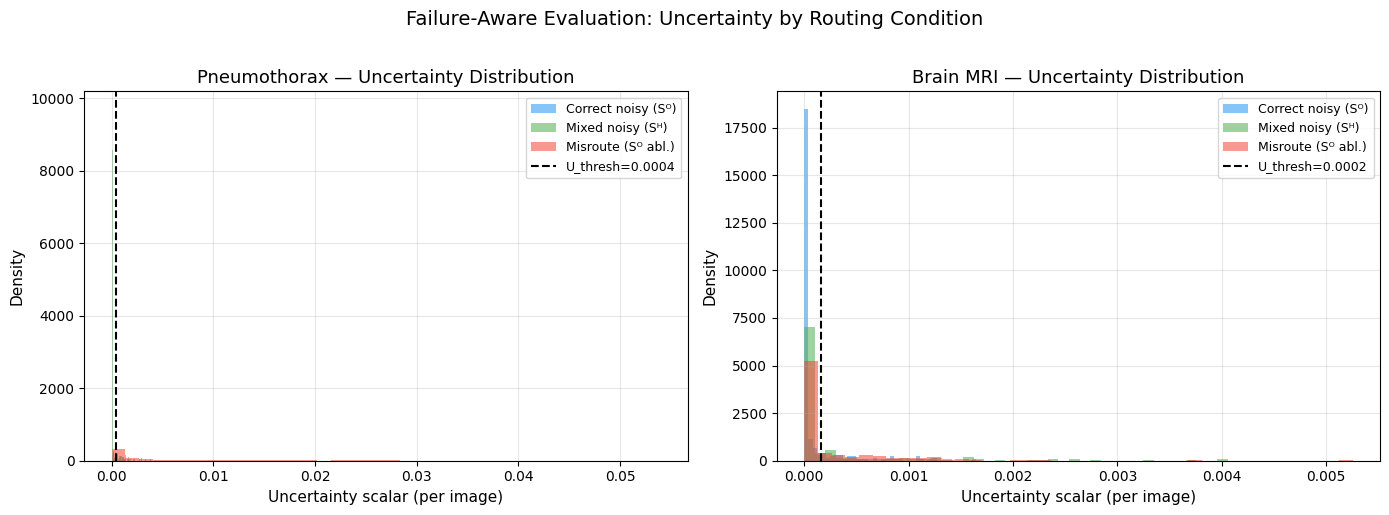

Histogram saved → failure_aware_uncertainty_histogram.png


In [50]:

# ============================================================
# UNCERTAINTY VISUALISATION
# Histogram: correct noisy vs misroute noisy (per modality)
# Supports detectability claim visually.
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {
    "Correct noisy (Sᴼ)": "#2196F3",
    "Mixed noisy (Sᴴ)":   "#4CAF50",
    "Misroute (Sᴼ abl.)": "#F44336",
}

_domain_thresh = {"Pneumothorax": U_THRESH["pneumo"], "Brain MRI": U_THRESH["brain"]}

for ax, (domain, dfs) in zip(axes,
                               [("Pneumothorax", pneumo_dfs),
                                ("Brain MRI",    brain_dfs)]):
    series = {
        "Correct noisy (Sᴼ)": dfs["3  Sᴼ noisy correct"]["unc_scalar"].values,
        "Mixed noisy (Sᴴ)":   dfs["4  Sᴴ noisy mixed"]["unc_scalar"].values,
        "Misroute (Sᴼ abl.)": dfs["5  Sᴼ(abl) misroute"]["unc_scalar"].values,
    }
    for name, vals in series.items():
        ax.hist(vals, bins=40, alpha=0.55, label=name,
                color=colors[name], edgecolor="none", density=True)

    _thr = _domain_thresh[domain]
    ax.axvline(_thr, color="black", linestyle="--", linewidth=1.5,
               label=f"U_thresh={_thr:.4f}")
    ax.set_title(f"{domain} — Uncertainty Distribution", fontsize=13)
    ax.set_xlabel("Uncertainty scalar (per image)", fontsize=11)
    ax.set_ylabel("Density", fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle("Failure-Aware Evaluation: Uncertainty by Routing Condition",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig("failure_aware_uncertainty_histogram.png", dpi=150, bbox_inches="tight")
plt.show()
print("Histogram saved → failure_aware_uncertainty_histogram.png")


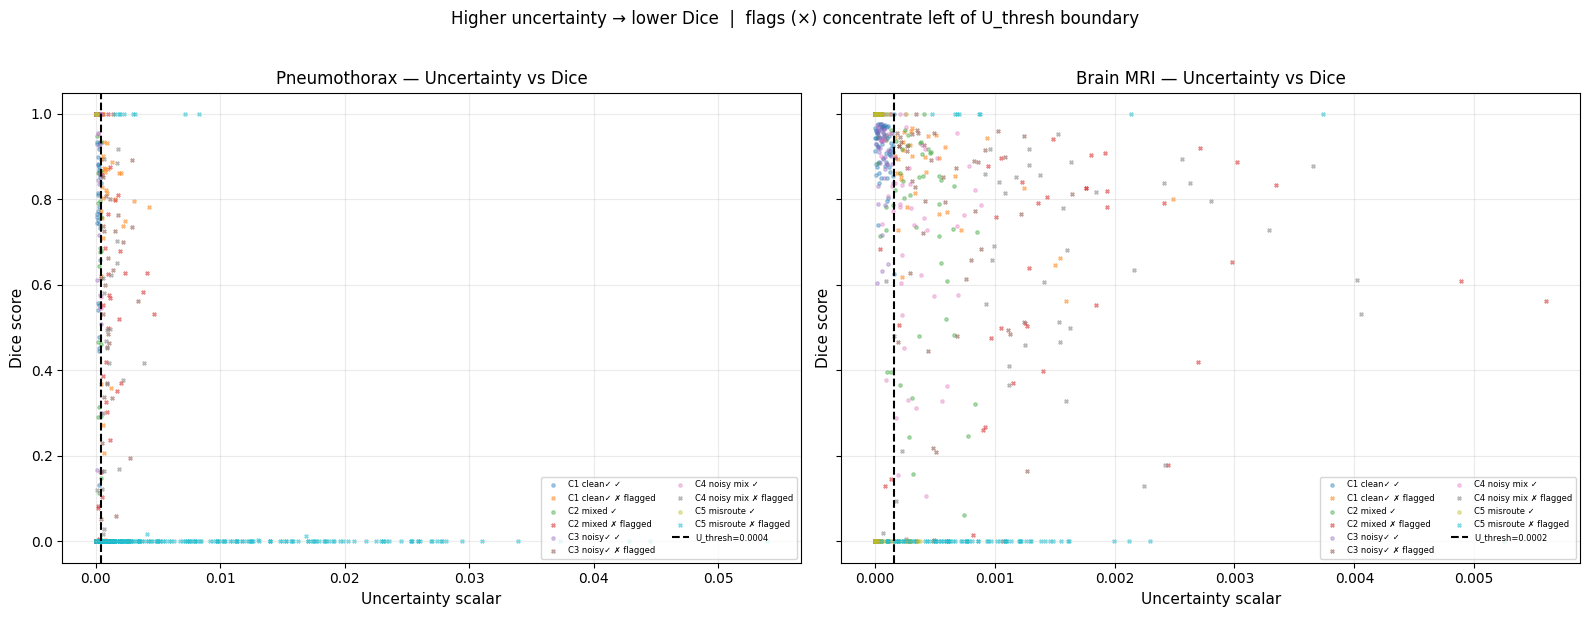

Saved → uncertainty_vs_dice_scatter.png


In [52]:
# ============================================================
# VIZ 1 — UNCERTAINTY vs DICE SCATTER PLOT
# One dot per test image, both domains × all 5 cases.
# Color = flagged / not-flagged.  Line = U_THRESH.
# ============================================================

CASE_SHORT = {
    "1  Sᴼ clean correct": "C1 clean✓",
    "2  Sᴴ clean mixed":   "C2 mixed",
    "3  Sᴼ noisy correct": "C3 noisy✓",
    "4  Sᴴ noisy mixed":   "C4 noisy mix",
    "5  Sᴼ(abl) misroute": "C5 misroute",
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

_domain_thresh2 = {"Pneumothorax": U_THRESH["pneumo"], "Brain MRI": U_THRESH["brain"]}

for ax, (domain_label, dfs) in zip(axes, [("Pneumothorax", pneumo_dfs),
                                           ("Brain MRI",    brain_dfs)]):
    for lbl, df in dfs.items():
        flagged     = df[df["flag"] == True]
        not_flagged = df[df["flag"] == False]
        short = CASE_SHORT[lbl]
        ax.scatter(not_flagged["unc_scalar"], not_flagged["dice_raw"],
                   s=6, alpha=0.35, label=f"{short} ✓")
        ax.scatter(flagged["unc_scalar"],     flagged["dice_raw"],
                   s=6, alpha=0.55, marker="x", label=f"{short} ✗ flagged")

    _thr2 = _domain_thresh2[domain_label]
    ax.axvline(_thr2, color="black", linestyle="--", linewidth=1.5,
               label=f"U_thresh={_thr2:.4f}")
    ax.set_xlabel("Uncertainty scalar", fontsize=11)
    ax.set_ylabel("Dice score", fontsize=11)
    ax.set_title(f"{domain_label} — Uncertainty vs Dice", fontsize=12)
    ax.legend(fontsize=6, ncol=2, loc="lower right")
    ax.grid(True, alpha=0.25)

plt.suptitle("Higher uncertainty → lower Dice  |  flags (×) concentrate left of U_thresh boundary",
             fontsize=12, y=1.02)
plt.tight_layout()
plt.savefig("uncertainty_vs_dice_scatter.png", dpi=150, bbox_inches="tight")

plt.show()
print("Saved → uncertainty_vs_dice_scatter.png")

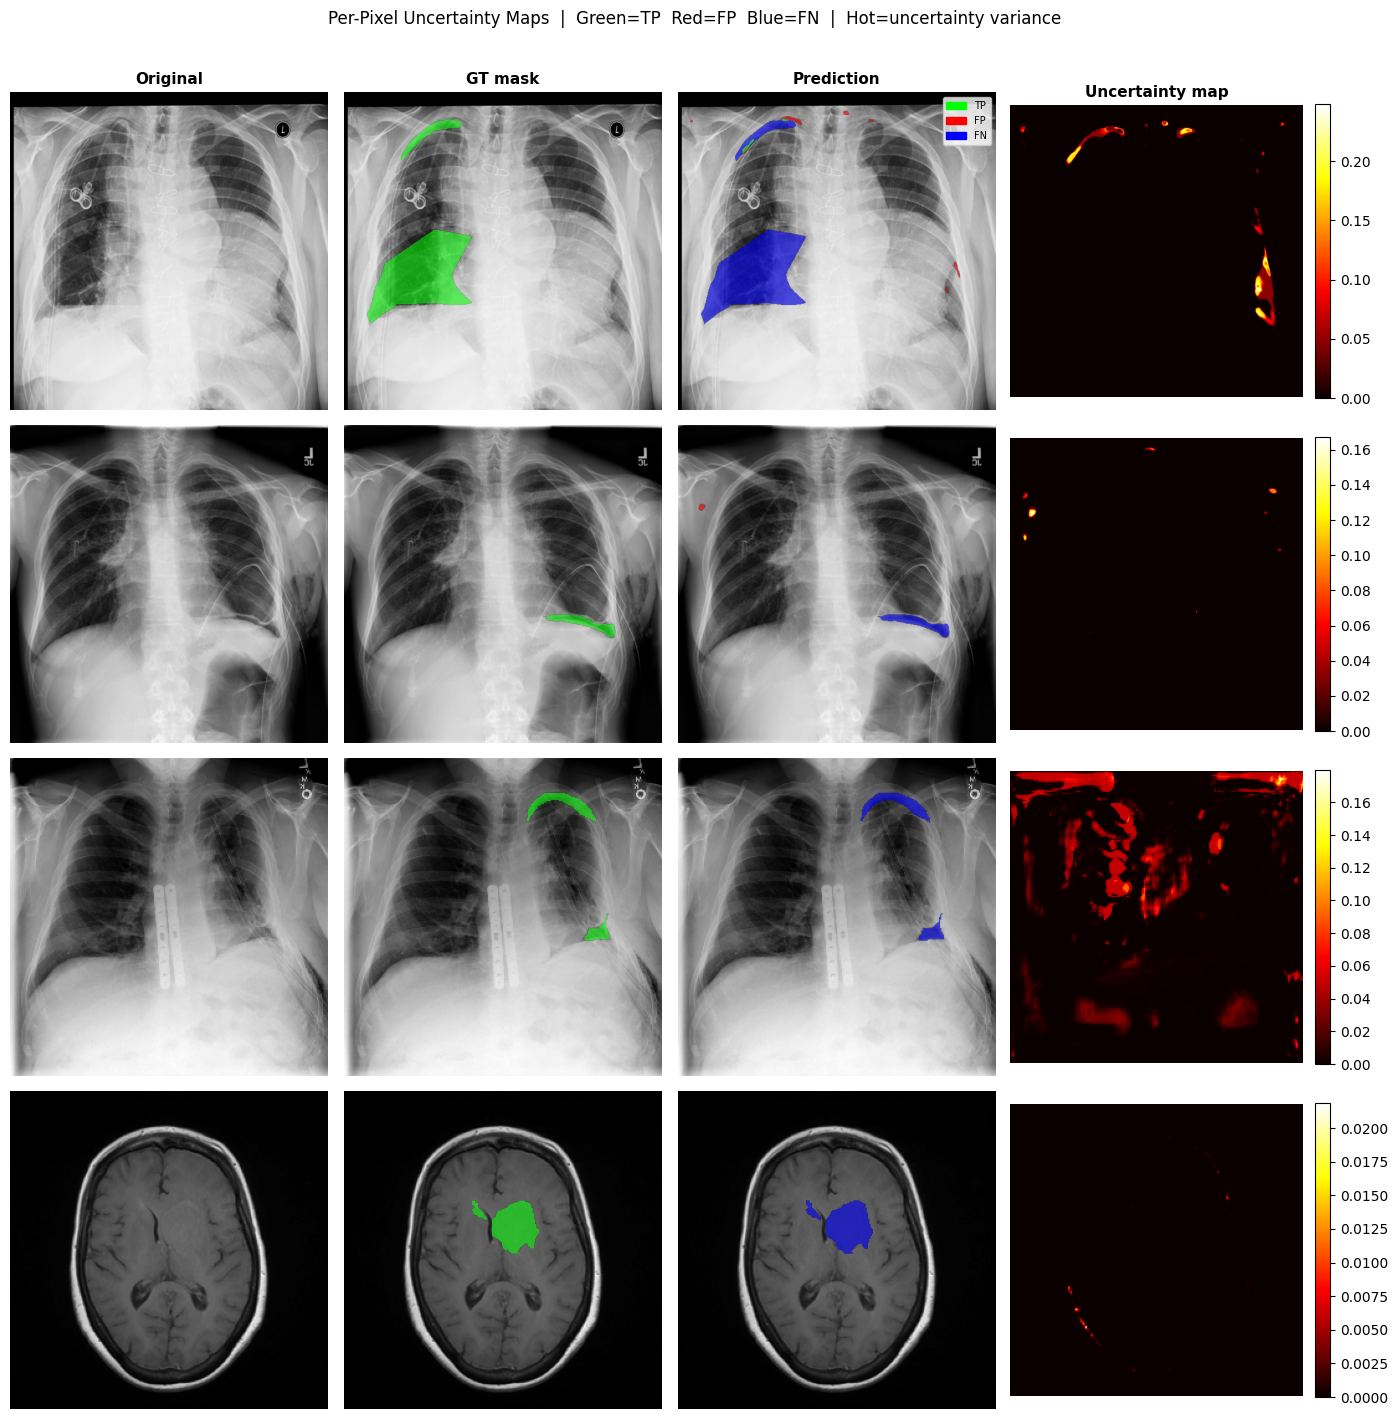

Saved → uncertainty_map_overlay.png


<Figure size 640x480 with 0 Axes>

In [53]:
# ============================================================
# VIZ 2 — PER-PIXEL UNCERTAINTY MAP OVERLAY
# For 2-4 hand-picked examples: original | GT | pred | unc heatmap
# ============================================================

@torch.no_grad()
def mc_dropout_spatial(model: nn.Module,
                       img_tensor: torch.Tensor,
                       n_mc: int = N_MC,
                       device: str = DEVICE):
    """
    Run MC Dropout on a single image tensor [C,H,W].
    Returns:
        mean_prob  : [H, W]  numpy
        pixel_var  : [H, W]  numpy  (spatial uncertainty map)
        pred_bin   : [H, W]  numpy bool
    """
    x = img_tensor.unsqueeze(0).to(device)       # [1,C,H,W]
    _enable_mc_dropout(model)
    probs = [torch.sigmoid(model(x)) for _ in range(n_mc)]
    model.eval()
    stacked   = torch.stack(probs, dim=0)         # [N,1,1,H,W]
    mean_prob = stacked.mean(0)[0, 0].cpu().numpy()
    pixel_var = stacked.var(0)[0, 0].cpu().numpy()
    pred_bin  = mean_prob > THRESHOLD
    return mean_prob, pixel_var, pred_bin


def load_single_image(img_path, image_size, out_channels):
    """Load, z-score, and tensorise one image — identical to SegDataset."""
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gray = cv2.resize(gray, (image_size, image_size))
    x    = gray.astype(np.float32)
    x    = (x - x.mean()) / (x.std() + 1e-6)
    if out_channels == 1:
        x_np = x[:, :, np.newaxis]
    else:
        x_np = np.stack([x, x, x], axis=-1)
    dummy = np.zeros((image_size, image_size, 1), dtype=np.float32)
    out   = get_clean_transform()(image=x_np, mask=dummy)
    return out["image"], gray   # tensor [C,H,W], raw gray [H,W]


def load_single_mask(mask_path, image_size, mask_threshold):
    m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if m is None:
        return np.zeros((image_size, image_size), dtype=np.float32)
    m = _max_pool_downsample_mask(m, image_size)
    return (m > mask_threshold).astype(np.float32)


def show_uncertainty_maps(examples, suptitle=""):
    """
    examples: list of dicts with keys:
        label, model, img_path, mask_path, image_size, in_channels, mask_threshold
    Columns: Original | GT overlay | Pred overlay | Uncertainty heatmap
    """
    n = len(examples)
    fig, axes = plt.subplots(n, 4, figsize=(14, 3.5 * n))
    if n == 1:
        axes = axes[np.newaxis, :]

    col_titles = ["Original", "GT mask", "Prediction", "Uncertainty map"]
    for ax, ct in zip(axes[0], col_titles):
        ax.set_title(ct, fontsize=11, fontweight="bold")

    for row, ex in enumerate(examples):
        img_tensor, gray = load_single_image(ex["img_path"], ex["image_size"], ex["in_channels"])
        gt_mask          = load_single_mask(ex["mask_path"], ex["image_size"], ex["mask_threshold"])

        mean_prob, pixel_var, pred_bin = mc_dropout_spatial(
            ex["model"], img_tensor, n_mc=N_MC, device=DEVICE)

        # display base image normalised to [0,1]
        disp = (gray - gray.min()) / (gray.max() - gray.min() + 1e-6)

        # col 0 — original
        axes[row, 0].imshow(disp, cmap="gray", vmin=0, vmax=1)

        # col 1 — GT overlay (green)
        axes[row, 1].imshow(disp, cmap="gray", vmin=0, vmax=1)
        gt_rgb = np.zeros((*disp.shape, 4))
        gt_rgb[..., 1] = gt_mask          # green channel
        gt_rgb[..., 3] = gt_mask * 0.55   # alpha
        axes[row, 1].imshow(gt_rgb)

        # col 2 — prediction overlay (blue = correct, red = FP/FN)
        tp = pred_bin & (gt_mask > 0)
        fp = pred_bin & (gt_mask == 0)
        fn = (~pred_bin) & (gt_mask > 0)
        pred_rgb = np.zeros((*disp.shape, 4))
        pred_rgb[tp, 1] = 0.9;  pred_rgb[tp, 3] = 0.55   # TP = green
        pred_rgb[fp, 0] = 0.9;  pred_rgb[fp, 3] = 0.65   # FP = red
        pred_rgb[fn, 2] = 0.9;  pred_rgb[fn, 3] = 0.65   # FN = blue
        axes[row, 2].imshow(disp, cmap="gray", vmin=0, vmax=1)
        axes[row, 2].imshow(pred_rgb)

        # col 3 — uncertainty heatmap
        im = axes[row, 3].imshow(pixel_var, cmap="hot",
                                  vmin=0, vmax=pixel_var.max() + 1e-8)
        plt.colorbar(im, ax=axes[row, 3], fraction=0.046, pad=0.04)

        for ax in axes[row]:
            ax.axis("off")

        unc_s = pixel_var.mean()
        axes[row, 0].set_ylabel(f"{ex['label']}\nunc={unc_s:.5f}",
                                 fontsize=8, rotation=0, labelpad=120, va="center")

    # legend patch
    import matplotlib.patches as mpatches
    patches = [mpatches.Patch(color="lime",  label="TP"),
               mpatches.Patch(color="red",   label="FP"),
               mpatches.Patch(color="blue",  label="FN")]
    axes[0, 2].legend(handles=patches, fontsize=7, loc="upper right")

    plt.suptitle(suptitle, fontsize=12, y=1.01)
    plt.tight_layout()
    plt.show()


# ── Pick 4 representative examples ─────────────────────────────────────────
# We use the case DataFrames to find good candidates (low-index for speed).
# lung: case 1 (clean correct), case 3 (noisy correct), case 5 (misroute)
# brain: case 1 (clean correct)

rng_ex = np.random.default_rng(7)   # fixed seed for reproducibility

def pick_idx(df, flagged: bool, gt_pos: bool = True, seed_offset: int = 0):
    """Pick a random index satisfying the flag / gt_positive condition."""
    sub = df[(df["flag"] == flagged) & (df["gt_positive"] == int(gt_pos))]
    if len(sub) == 0:
        sub = df[df["flag"] == flagged]
    return int(sub.index[rng_ex.integers(len(sub))])


lung_case1_df  = pneumo_dfs["1  Sᴼ clean correct"]
lung_case3_df  = pneumo_dfs["3  Sᴼ noisy correct"]
lung_case5_df  = pneumo_dfs["5  Sᴼ(abl) misroute"]
brain_case1_df = brain_dfs["1  Sᴼ clean correct"]

idx_l1 = pick_idx(lung_case1_df,  flagged=False, gt_pos=True)
idx_l3 = pick_idx(lung_case3_df,  flagged=False, gt_pos=True)
idx_l5 = pick_idx(lung_case5_df,  flagged=True,  gt_pos=True)
idx_b1 = pick_idx(brain_case1_df, flagged=False, gt_pos=True)

unc_examples = [
    dict(label="C1 clean✓ (lung, not flagged)",
         model=pneumo_model,
         img_path=lung_test_pairs[idx_l1][0],
         mask_path=lung_test_pairs[idx_l1][1],
         image_size=pneumo_sz, in_channels=pneumo_meta["in_channels"], mask_threshold=127),

    dict(label="C3 noisy✓ (lung, not flagged)",
         model=pneumo_model,
         img_path=lung_test_pairs[idx_l3][0],
         mask_path=lung_test_pairs[idx_l3][1],
         image_size=pneumo_sz, in_channels=pneumo_meta["in_channels"], mask_threshold=127),

    dict(label="C5 misroute (lung, FLAGGED)",
         model=brain_model,
         img_path=lung_test_pairs[idx_l5][0],
         mask_path=lung_test_pairs[idx_l5][1],
         image_size=brain_sz, in_channels=brain_meta["in_channels"], mask_threshold=127),

    dict(label="C1 clean✓ (brain, not flagged)",
         model=brain_model,
         img_path=brain_test_pairs[idx_b1][0],
         mask_path=brain_test_pairs[idx_b1][1],
         image_size=brain_sz, in_channels=brain_meta["in_channels"], mask_threshold=0),
]

show_uncertainty_maps(unc_examples,
    suptitle="Per-Pixel Uncertainty Maps  |  Green=TP  Red=FP  Blue=FN  |  Hot=uncertainty variance")
plt.savefig("uncertainty_map_overlay.png", dpi=150, bbox_inches="tight")
print("Saved → uncertainty_map_overlay.png")


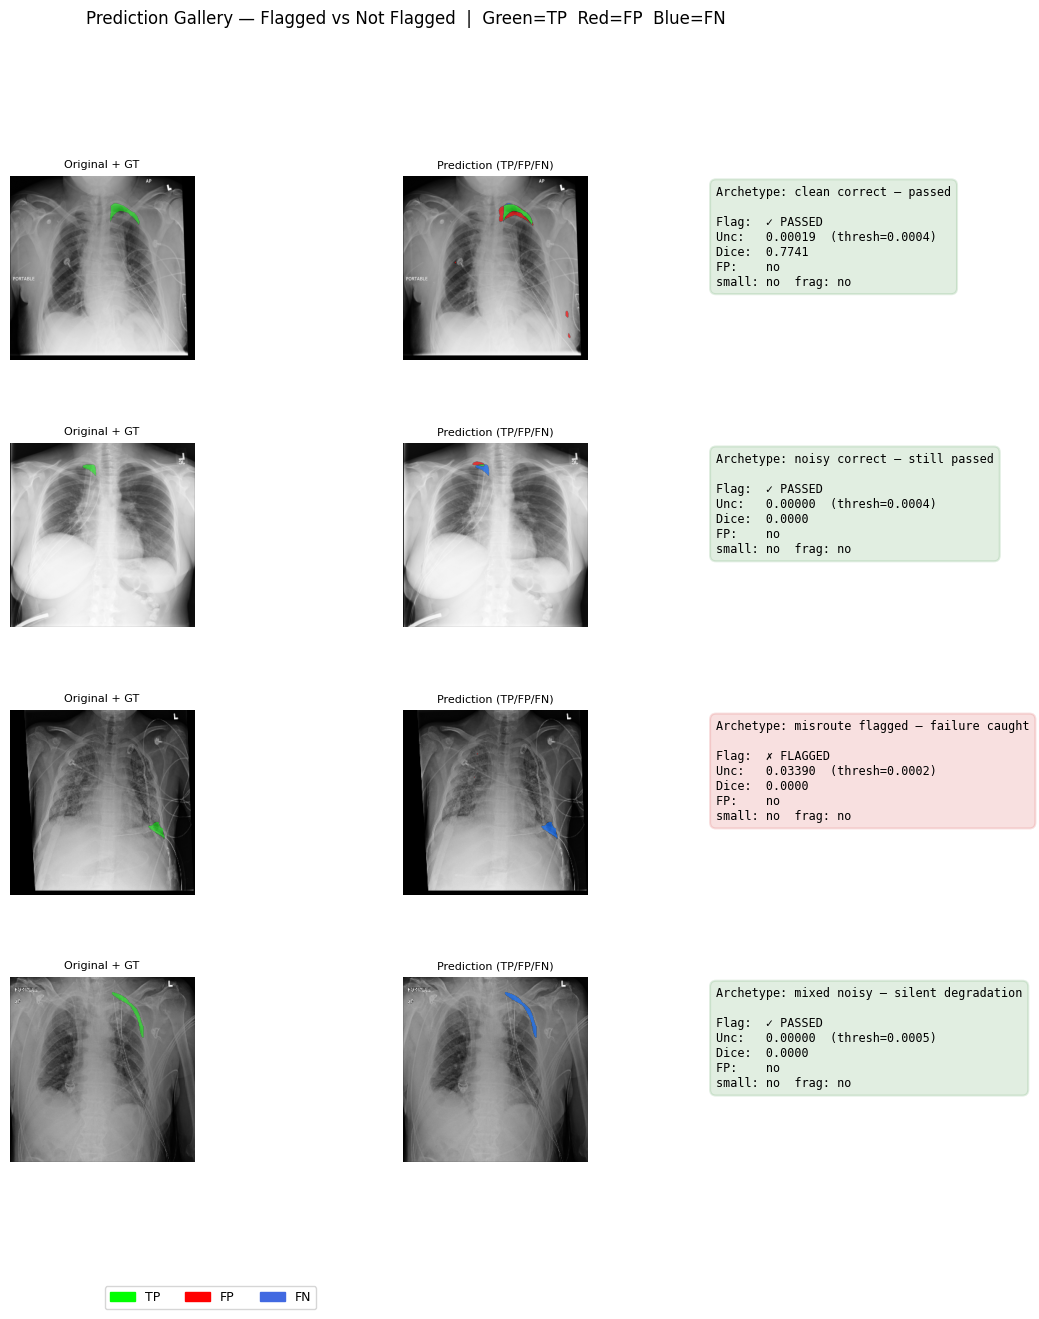

Saved → prediction_gallery_flagged.png


In [54]:

# ============================================================
# VIZ 3 — PREDICTION OVERLAY GALLERY  (flagged vs not flagged)
# 4 archetypal examples (lung domain): clean pass, noisy pass,
# misroute flagged, mixed-model silent degradation.
# Columns: Original + GT | Prediction (TP/FP/FN) | Annotation
# ============================================================
import matplotlib.gridspec as gridspec


def make_overlay(disp_gray, mask, color_rgb=(0, 1, 0), alpha=0.55):
    """Return an RGBA overlay for imshow."""
    rgba = np.zeros((*disp_gray.shape, 4))
    rgba[mask > 0, 0] = color_rgb[0]
    rgba[mask > 0, 1] = color_rgb[1]
    rgba[mask > 0, 2] = color_rgb[2]
    rgba[mask > 0, 3] = alpha
    return rgba


def show_prediction_gallery(gallery_specs, suptitle=""):
    """
    gallery_specs: list of dicts with keys:
        archetype, label, model, img_path, mask_path,
        image_size, in_channels, mask_threshold, df, df_idx
    Columns: Original + GT | Prediction (TP/FP/FN) | Annotation box
    """
    n   = len(gallery_specs)
    fig = plt.figure(figsize=(13, 3.2 * n))
    gs  = gridspec.GridSpec(n, 3, width_ratios=[1, 1, 0.6],
                            figure=fig, hspace=0.45, wspace=0.08)

    for row, spec in enumerate(gallery_specs):
        img_tensor, gray = load_single_image(spec["img_path"], spec["image_size"],
                                              spec["in_channels"])
        gt_mask          = load_single_mask(spec["mask_path"], spec["image_size"],
                                             spec["mask_threshold"])

        with torch.no_grad():
            spec["model"].eval()
            logit    = spec["model"](img_tensor.unsqueeze(0).to(DEVICE))
            pred_bin = (torch.sigmoid(logit)[0, 0].cpu().numpy() > THRESHOLD).astype(np.float32)

        disp = (gray - gray.min()) / (gray.max() - gray.min() + 1e-6)

        # col 0 — original + GT (green)
        ax0 = fig.add_subplot(gs[row, 0])
        ax0.imshow(disp, cmap="gray", vmin=0, vmax=1)
        ax0.imshow(make_overlay(disp, gt_mask, (0, 1, 0), 0.5))
        ax0.axis("off")
        ax0.set_title("Original + GT", fontsize=8)

        # col 1 — prediction (TP green / FP red / FN blue)
        ax1 = fig.add_subplot(gs[row, 1])
        tp = pred_bin * gt_mask
        fp = pred_bin * (1 - gt_mask)
        fn = (1 - pred_bin) * gt_mask
        ax1.imshow(disp, cmap="gray", vmin=0, vmax=1)
        ax1.imshow(make_overlay(disp, tp, (0,   1,   0), 0.55))
        ax1.imshow(make_overlay(disp, fp, (1,   0,   0), 0.65))
        ax1.imshow(make_overlay(disp, fn, (0, 0.4,   1), 0.65))
        ax1.axis("off")
        ax1.set_title("Prediction (TP/FP/FN)", fontsize=8)

        # col 2 — annotation text box
        ax2 = fig.add_subplot(gs[row, 2])
        ax2.axis("off")

        df_row  = spec["df"].iloc[spec["df_idx"]]
        flag    = bool(df_row["flag"])
        unc     = df_row["unc_scalar"]
        dice    = df_row["dice_raw"]
        fp_flag = bool(df_row["is_fp_raw"])
        too_sm  = bool(df_row["too_small"])
        too_fr  = bool(df_row["too_fragmented"])

        flag_color = "#d32f2f" if flag else "#388e3c"
        flag_sym   = "✗ FLAGGED" if flag else "✓ PASSED"

        text_lines = [
            f"Archetype: {spec['archetype']}",
            "",
            f"Flag:  {flag_sym}",
            f"Unc:   {unc:.5f}  (thresh={spec['u_thresh']:.4f})",
            f"Dice:  {dice:.4f}",
            f"FP:    {'yes' if fp_flag else 'no'}",
            f"small: {'yes' if too_sm else 'no'}  frag: {'yes' if too_fr else 'no'}",
        ]
        ax2.text(0.05, 0.95, "\n".join(text_lines),
                 transform=ax2.transAxes,
                 fontsize=8.5, va="top", family="monospace",
                 bbox=dict(boxstyle="round,pad=0.5", facecolor=flag_color,
                           alpha=0.15, edgecolor=flag_color, linewidth=1.5))

        ax0.set_ylabel(spec["label"], fontsize=8, rotation=0,
                       labelpad=110, va="center")

    import matplotlib.patches as mpatches
    lg = [mpatches.Patch(color="lime",       label="TP"),
          mpatches.Patch(color="red",         label="FP"),
          mpatches.Patch(color="royalblue",   label="FN")]
    fig.legend(handles=lg, loc="lower center", ncol=3, fontsize=9,
               bbox_to_anchor=(0.35, -0.01))

    plt.suptitle(suptitle, fontsize=12, y=1.01)
    plt.tight_layout()
    plt.savefig("prediction_gallery_flagged.png", dpi=150, bbox_inches="tight")
    plt.show()
    print("Saved → prediction_gallery_flagged.png")


# ── Helper: pick one matching example from a DataFrame ────────────────────
def find_example(df, pairs, flagged, gt_pos=True, high_dice=None, seed=0):
    """Return (df_idx, img_path, mask_path) for a row matching the criteria."""
    rng2 = np.random.default_rng(seed)
    sub  = df[(df["flag"] == flagged) & (df["gt_positive"] == int(gt_pos))]
    if high_dice is not None:
        med = sub["dice_raw"].median()
        sub = sub[sub["dice_raw"] >= med] if high_dice else sub[sub["dice_raw"] < med]
    if len(sub) == 0:
        sub = df
    idx = int(sub.index[rng2.integers(len(sub))])
    return idx, pairs[idx][0], pairs[idx][1]


# ── Pick one example per archetype ────────────────────────────────────────
# Archetype 1 — clean correct specialist, not flagged, good Dice
a1_idx, a1_img, a1_msk = find_example(pneumo_dfs["1  Sᴼ clean correct"],
                                       lung_test_pairs, flagged=False, gt_pos=True,
                                       high_dice=True, seed=1)

# Archetype 2 — noisy correct specialist, still not flagged
a2_idx, a2_img, a2_msk = find_example(pneumo_dfs["3  Sᴼ noisy correct"],
                                       lung_test_pairs, flagged=False, gt_pos=True,
                                       high_dice=True, seed=2)

# Archetype 3 — misroute (brain model on lung), flagged (failure caught)
a3_idx, a3_img, a3_msk = find_example(pneumo_dfs["5  Sᴼ(abl) misroute"],
                                       lung_test_pairs, flagged=True, gt_pos=True,
                                       high_dice=False, seed=3)

# Archetype 4 — mixed model, noisy, NOT flagged but lower Dice (silent degradation)
a4_idx, a4_img, a4_msk = find_example(pneumo_dfs["4  Sᴴ noisy mixed"],
                                       lung_test_pairs, flagged=False, gt_pos=True,
                                       high_dice=False, seed=4)

gallery = [
    dict(archetype="clean correct — passed",
         label="C1 Lung clean\nspecialist ✓",
         model=pneumo_model, df=pneumo_dfs["1  Sᴼ clean correct"], df_idx=a1_idx,
         img_path=a1_img, mask_path=a1_msk,
         image_size=pneumo_sz, in_channels=pneumo_meta["in_channels"], mask_threshold=127,
         u_thresh=U_THRESH["pneumo"]),

    dict(archetype="noisy correct — still passed",
         label="C3 Lung noisy\nspecialist ✓",
         model=pneumo_model, df=pneumo_dfs["3  Sᴼ noisy correct"], df_idx=a2_idx,
         img_path=a2_img, mask_path=a2_msk,
         image_size=pneumo_sz, in_channels=pneumo_meta["in_channels"], mask_threshold=127,
         u_thresh=U_THRESH["pneumo"]),

    dict(archetype="misroute flagged — failure caught",
         label="C5 Lung misroute\nbrain model ✗",
         model=brain_model, df=pneumo_dfs["5  Sᴼ(abl) misroute"], df_idx=a3_idx,
         img_path=a3_img, mask_path=a3_msk,
         image_size=brain_sz, in_channels=brain_meta["in_channels"], mask_threshold=127,
         u_thresh=U_THRESH["brain"]),

    dict(archetype="mixed noisy — silent degradation",
         label="C4 Lung noisy\nmixed (silent)",
         model=mixed_model, df=pneumo_dfs["4  Sᴴ noisy mixed"], df_idx=a4_idx,
         img_path=a4_img, mask_path=a4_msk,
         image_size=mixed_sz, in_channels=mixed_meta["in_channels"], mask_threshold=127,
         u_thresh=U_THRESH["mixed_lung"]),
]

show_prediction_gallery(

    gallery,

    suptitle="Prediction Gallery — Flagged vs Not Flagged  |  Green=TP  Red=FP  Blue=FN",)